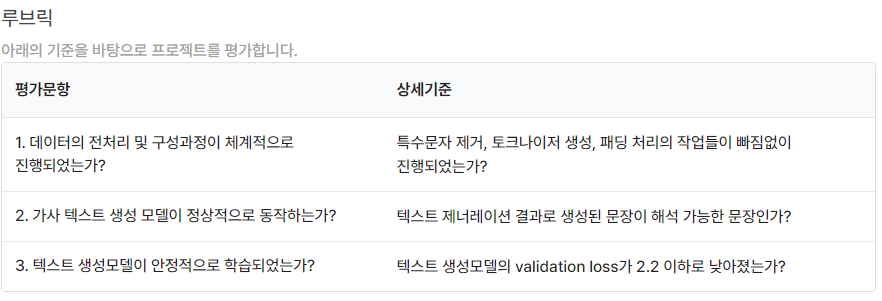

# 6-7. 프로젝트: 멋진 작사가 만들기

### 라이브러리 버전을 확인해 봅니다
----
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import glob 
import os, re 
import numpy as np
import tensorflow as tf


print(tf.__version__)

2.5.0


### Step 1. 데이터 다운로드
----
이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

### Step 2. 데이터 읽어오기
----
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!


```pyton
import glob
import os

txt_file_path = './data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])
```

위 코드대로 파일을 열면 
''cp949' codec can't decode byte 0xe2 in position 4: illegal multibyte sequence'라는 오류가 발생하는 경우가 있다. 
text파일의 코덱의 문제이다. 파일 읽어 들일때 encoding 파라미터를 지정해서 해결 할 수 있다. 

In [2]:
txt_file_path = './data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding='UTF8') as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


In [3]:
raw_corpus[:20]

['Looking for some education',
 'Made my way into the night',
 'All that bullshit conversation',
 "Baby, can't you read the signs? I won't bore you with the details, baby",
 "I don't even wanna waste your time",
 "Let's just say that maybe",
 'You could help me ease my mind',
 "I ain't Mr. Right But if you're looking for fast love",
 "If that's love in your eyes",
 "It's more than enough",
 'Had some bad love',
 "So fast love is all that I've got on my mind Ooh, ooh",
 'Ooh, ooh Looking for some affirmation',
 'Made my way into the sun',
 'My friends got their ladies',
 "And they're all having babies",
 "I just wanna have some fun I won't bore you with the details, baby",
 "I don't even wanna waste your time",
 "Let's just say that maybe",
 'You could help me ease my mind']

### Step 3. 데이터 정제
----
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,'¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,'¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [5]:
len(raw_corpus[1].split())

6

In [6]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 "<start> i don ' t even wanna waste your time <end>",
 "<start> let ' s just say that maybe <end>",
 '<start> you could help me ease my mind <end>',
 "<start> if that ' s love in your eyes <end>",
 "<start> it ' s more than enough <end>",
 '<start> had some bad love <end>',
 '<start> ooh , ooh looking for some affirmation <end>']

In [7]:
corpus[100:200]

['<start> tears are gonna fall , rolling in the deep <end>',
 '<start> we could have had it all <end>',
 '<start> rolling in the deep <end>',
 '<start> you had my heart inside of your hand <end>',
 '<start> count your blessings to find what you look for woah <end>',
 '<start> turn my sorrow into treasured gold woah <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> we could have had it all <end>',
 '<start> tears are gonna fall , rolling in the deep <end>',
 '<start> we could have had it all <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> it all , it all , it all <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> rolling in the deep <end>',
 '<start> tears are gonna fall , rolling in the deep <end>',
 '<start> you had my heart inside of your hand <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> and you played it to the beat <end>',
 "<start> you ' re gonna wish you never had met

### Step 4. 평가 데이터셋 분리
----
#### 훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 290  29 ...   0   0   0]
 [  2 220  14 ...   0   0   0]
 [  2  25  16 ...   0   0   0]
 ...
 [  2  22  77 ...   0   0   0]
 [  2  41  26 ...   0   0   0]
 [  2  22  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x0000015E359A44C0>


In [9]:
enc_train, enc_val, dec_train, dec_val = # <코드 작성>

SyntaxError: invalid syntax (846719211.py, line 1)

### Step 5. 인공지능 만들기
----
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.

```pyton
model.fit(dataset, epochs=30)
```

하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [ ]:
#Loss
# tf.keras.losses.SparseCategoricalCrossentropy : https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다. 여유를 가지고 작업하시면 좋아요 :)

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [ ]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

__Q4. 모델이 생성한 가사 한 줄을 제출하세요.__
> 